In [1]:
from astroquery.gaia import Gaia
import numpy as np
import matplotlib.pyplot as plt

In [2]:
query='''SELECT m.source_id, m.parallax, m.phot_bp_mean_mag, m.phot_rp_mean_mag, v.pf, m.phot_g_mean_mag
  from gaiadr3.gaia_source as m, gaiadr3.vari_cepheid as v
  where m.source_id = v.source_id and
  m.parallax is not null and
  v.pf>0 and
  m.has_epoch_photometry = 'True' and
  m.parallax_over_error > 5 and
  m.phot_g_mean_flux_over_error > 5
  order by v.pf'''
job=Gaia.launch_job_async(query)
r=job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [3]:
r[0:5]

source_id,parallax,phot_bp_mean_mag,phot_rp_mean_mag,pf,phot_g_mean_mag
,mas,mag,mag,d,mag
int64,float64,float32,float32,float64,float32
5422477922959825792,0.40067803349571696,16.81692,14.294267,0.5597106717764326,15.444394
5864522588553955584,0.29549190897169186,15.908997,13.872912,0.5990258658944467,14.883258
5188379665334866176,0.30448090312973586,13.158561,12.495677,0.6219627800893595,12.896799
3585871223384619648,0.1555390131537249,14.584338,13.948349,0.6404087854880521,14.344771
4344670860870864640,0.2203795313169121,14.320211,13.296128,0.7865289926475708,13.927822


In [4]:
retrieval_type = 'EPOCH_PHOTOMETRY'         
data_structure = 'INDIVIDUAL'   
data_release   = 'Gaia DR3' 

datalink = Gaia.load_data(ids=r['source_id'], data_release = data_release, retrieval_type=retrieval_type, data_structure = data_structure, verbose = False, output_file = None)
dl_keys  = [inp for inp in datalink.keys()]
dl_keys.sort()

print()
print(f'The following Datalink products have been downloaded:')
for dl_key in dl_keys:
    print(f' * {dl_key}')


The following Datalink products have been downloaded:
 * EPOCH_PHOTOMETRY-Gaia DR3 1113929871645836672.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1208200864738741376.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1306279466601099904.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1328057184175359488.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1328057867076964864.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1328059413265281920.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1335461398554969472.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 154255575798532096.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1596081113587582464.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1659676827481828608.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1734124248699204096.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 174489098011145216.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1750217486861133440.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1765149340099555840.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1785352625740690432.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1789512215668452864.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1808020329279916288.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 18116184080458008

In [5]:
def plot_e_phot(inp_table, colours  = ['green', 'red', 'blue'], title = 'Epoch photometry'):
    ""
    "Epoch photometry plotter. 'inp_table' MUST be an Astropy-table object."
    ""
    fig      = plt.figure(figsize=[15,5])
    xlabel   = f'JD date [{inp_table["time"].unit}]'
    ylabel   = f'magnitude [{inp_table["mag"].unit}]'
    gbands   = ['G', 'RP', 'BP']
    colours  = iter(colours)

    plt.gca().invert_yaxis()
    for band in gbands:
        phot_set = inp_table[inp_table['band'] == band]
        plt.plot(phot_set['time'], phot_set['mag'], 'o', label = band, color = next(colours))
    plt.title('Epoch Photometry')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend() 
    plt.grid()
    plt.show()

def extract_dl_ind(datalink_dict, key, figsize = [15,5],plot=True):
    ""
    "Extract individual DataLink products and export them to an Astropy Table"
    ""
    dl_out  = datalink_dict[key][0].to_table()
    if 'time' in dl_out.keys() and plot==True:
        plot_e_phot(dl_out, colours  = ['green', 'red', 'blue'], title = 'Epoch photometry')
    return dl_out

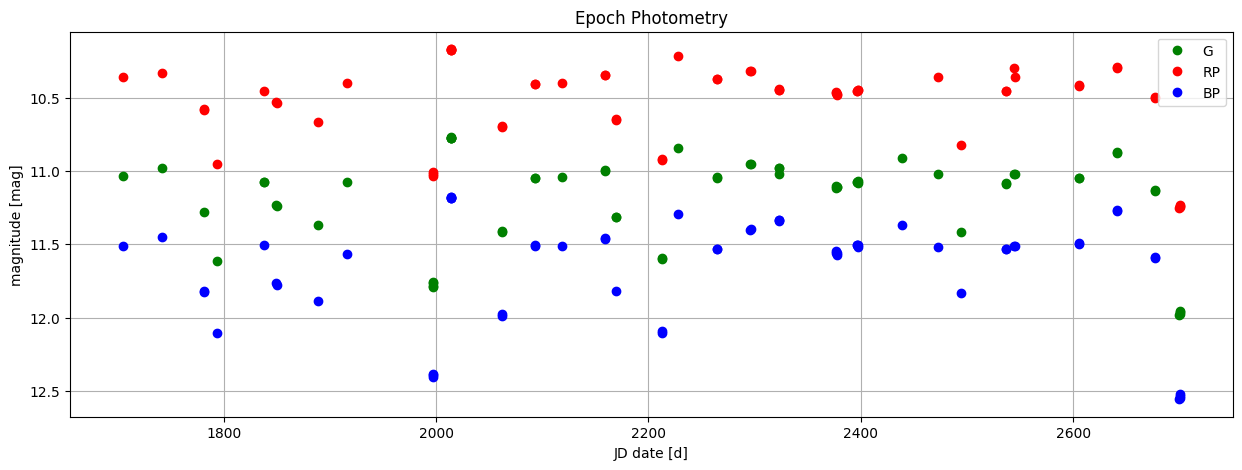

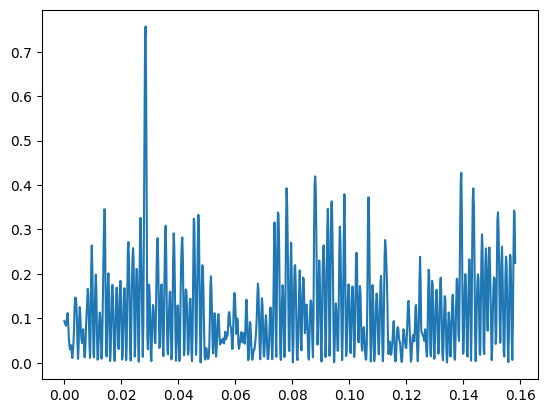

In [83]:
from astropy.timeseries import LombScargle

dl_key  = 'EPOCH_PHOTOMETRY-Gaia DR3 1113929871645836672.xml'
dl_out  = extract_dl_ind(datalink, dl_key, figsize=[20,7]) 
frequency,power=LombScargle(dl_out[dl_out['band']=='G']['time'],dl_out[dl_out['band']=='G']['mag']).autopower()
plt.plot(frequency,power)
plt.show()

In [7]:
dl_out[0:5]

source_id,transit_id,band,time,mag,flux,flux_error,flux_over_error,rejected_by_photometry,rejected_by_variability,other_flags,solution_id
,,,d,mag,electron / s,electron / s,,,,,
int64,int64,object,float64,float64,float64,float64,float32,bool,bool,int64,int64
1113929871645836672,17043300638803725,G,1705.0618115528753,11.034948789103318,726051.1726333069,1292.6316234968283,561.6845,False,False,4198401,375316653866487564
1113929871645836672,19096454289187515,G,1742.1944699213777,10.976913805916949,765916.145348983,1241.7721622332379,616.7928,False,False,4097,375316653866487564
1113929871645836672,21268445074482273,G,1781.4758652279104,11.277793738090764,580536.1274646493,1276.1008437390904,454.92966,False,False,4097,375316653866487564
1113929871645836672,21955784451178601,G,1793.9064017630267,11.611970944394674,426735.10290682747,1057.55861846626,403.50964,False,False,4198845,375316653866487564
1113929871645836672,24371212530640555,G,1837.588250082682,11.076690965886327,698667.2086120667,922.9157218254935,757.02167,False,False,4097,375316653866487564


In [126]:
periodData=[]

dl_keys= ['EPOCH_PHOTOMETRY-Gaia DR3 {}.xml'.format(i) for i in r['source_id']]

for dl_key in dl_keys:
    dl_out  = extract_dl_ind(datalink, dl_key, plot=False)
    dl_g=dl_out[dl_out['band']=='G']
    frequency1,power1=LombScargle(list(dl_g['time']),list(dl_g['mag']),0.01).autopower(minimum_frequency=0.0005,maximum_frequency=1.5)    
    periodData.append(1/frequency1[np.argmax(power1)])

In [56]:
abs_mags=[r['phot_g_mean_mag']-5*np.log10(100/r['parallax'])]

Text(0.5, 1.0, 'Period Luminosity Relationship: Lomb Scargle')

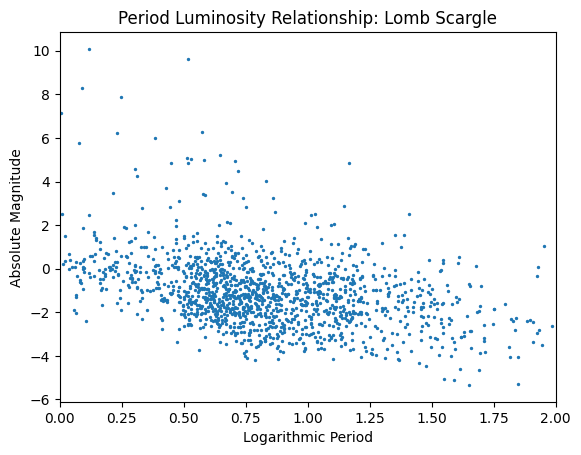

In [127]:
logx=np.log10(periods)
plt.scatter(logx,abs_mags,s=2)
plt.xlim(0,2)
plt.xlabel('Logarithmic Period')
plt.ylabel('Absolute Magnitude')
plt.title('Period Luminosity Relationship: Lomb Scargle')

Text(0.5, 1.0, 'Period Luminosity Relationship: Lomb Scargle')

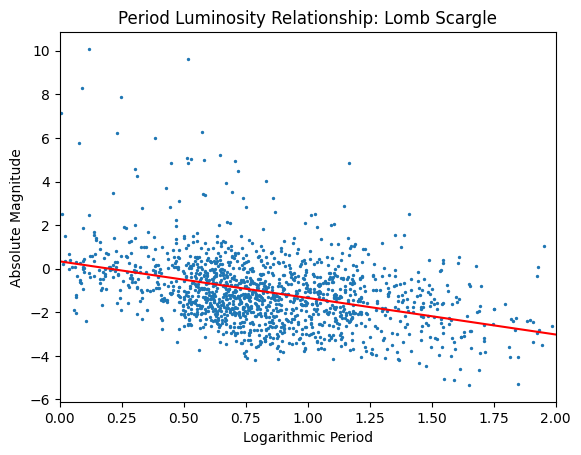

In [128]:
from scipy.optimize import curve_fit

def line(x,m,c):
    return m*x+c

popt,pcov=curve_fit(line,logx,abs_mags[0])

plt.scatter(logx,abs_mags,s=2)
plt.plot(logx,logx*popt[0]+popt[1],color='red')
plt.xlim(0,2)
plt.xlabel('Logarithmic Period')
plt.ylabel('Absolute Magnitude')
plt.title('Period Luminosity Relationship: Lomb Scargle')

In [129]:
popt

array([-1.67799139,  0.33594401])

Text(0.5, 1.0, 'Period Luminosity Relationship: Gaia Data')

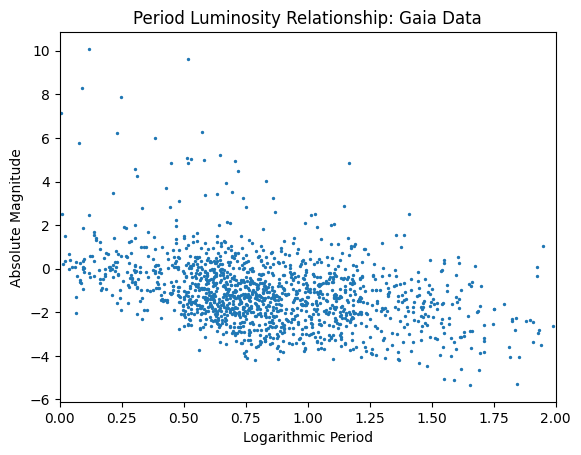

In [75]:
logxp=np.log10(r['pf'])
plt.scatter(logxp,abs_mags,s=2)
plt.xlim(0,2)
plt.xlabel('Logarithmic Period')
plt.ylabel('Absolute Magnitude')
plt.title('Period Luminosity Relationship: Gaia Data')

Text(0.5, 1.0, 'Period Luminosity Relationship: Gaia Data')

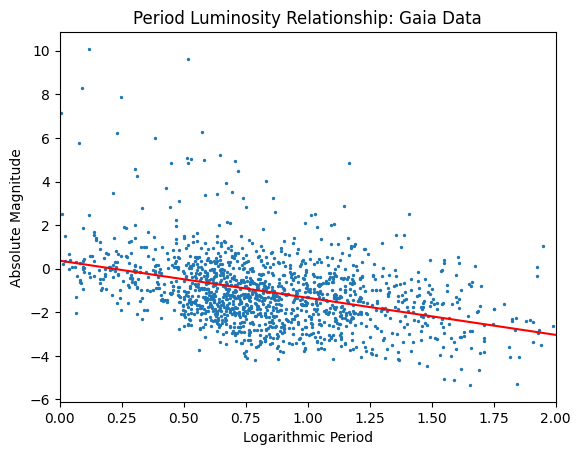

In [81]:
popt,pcov=curve_fit(line,logxp,abs_mags[0])

plt.scatter(logxp,abs_mags,s=2)
plt.plot(logxp,logxp*popt[0]+popt[1],color='red')
plt.xlim(0,2)
plt.xlabel('Logarithmic Period')
plt.ylabel('Absolute Magnitude')
plt.title('Period Luminosity Relationship: Gaia Data')

In [82]:
popt

array([-1.70140261,  0.36610869])